In [3]:
# """Run the cell to record currents and ionic concentrations."""

# Copyright 2023 Blue Brain Project / EPFL

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
from pathlib import Path

from bluepyopt import ephys
from emodelrunner.load import load_emodel_params
from emodelrunner.load import load_mechanisms
from emodelrunner.load import load_unoptimized_parameters
from emodelrunner.morphology.morphology import SSCXNrnFileMorphology
from emodelrunner.output import write_responses
from emodelrunner.recordings import RecordingCustom

logger = logging.getLogger()

In [2]:
def absolute_path(path):
    path_to_dir = Path().parent.absolute()
    return str(path_to_dir / path)


def create_cell():
    unopt_params_path = absolute_path("config/params/pyr.json")

    mechs = load_mechanisms(unopt_params_path)

    params = load_unoptimized_parameters(unopt_params_path, v_init=-80, celsius=34)

    morph_path = absolute_path(
        "morphology/dend-C231296A-P4B2_axon-C200897C-P2_-_Scale_x1.000_y0.975_z1.000.asc"
    )
    morph = SSCXNrnFileMorphology(
        morphology_path=morph_path,
        do_replace_axon=True,
    )

    return ephys.models.CellModel(
        name="cADpyr_L4UPC",
        morph=morph,
        mechs=mechs,
        params=params,
    )


def create_recordings(soma_loc):
    recs = []
    currents = [
        "i_pas",
        "ihcn_Ih",
        "ica_Ca_HVA2",
        "ica_Ca_LVAst",
        "ik_SK_E2",
        "ik_SKv3_1",
        "ik_K_Pst",
        "ik_K_Tst",
        "ina_NaTg",
    ]
    ionic_concentrations = ["cai", "ki", "nai"]

    recs.append(RecordingCustom(name="v", location=soma_loc, variable="v"))

    for var in currents:
        recs.append(RecordingCustom(name=var, location=soma_loc, variable=var))

    for var in ionic_concentrations:
        recs.append(RecordingCustom(name=var, location=soma_loc, variable=var))

    return recs

def create_stimuli(soma_loc, threshold):
    # create step stimulus
    stim = ephys.stimuli.NrnSquarePulse(
        step_amplitude=threshold*(0.34859375/250.0),
        step_delay=700.0,
        step_duration=2000.0,
        location=soma_loc,
        total_duration=3000.0,
    )

    # create holding stimulus
    hold_stim = ephys.stimuli.NrnSquarePulse(
        step_amplitude=-0.0896244038173676,
        step_delay=0.0,
        step_duration=3000.0,
        location=soma_loc,
        total_duration=3000.0,
    )

    return [stim, hold_stim]


def run(threshold):
    cell = create_cell()

    release_params = load_emodel_params(
        params_path=absolute_path("config/params/final.json"), emodel="cADpyr_L4UPC"
    )

    sim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)

    soma_loc = ephys.locations.NrnSeclistCompLocation(
        name="soma", seclist_name="somatic", sec_index=0, comp_x=0.5
    )

    recs = create_recordings(soma_loc)

    stims = create_stimuli(soma_loc, threshold)

    protocol = ephys.protocols.SweepProtocol("step_protocol", stims, recs, cvode_active=False)

    logger.info("Python Recordings Running...")
    responses = protocol.run(
        cell_model=cell, param_values=release_params, sim=sim, isolate=False
    )

    write_responses(responses, absolute_path("python_recordings"))

    logger.info("Python Recordings Done")

In [4]:
from pathlib import Path
import numpy as np

import currentscape

def plot(threshold):
    data_dir = absolute_path("python_recordings")
    currs = [
        "i_pas",
        "ihcn_Ih",
        "ica_Ca_HVA2",
        "ica_Ca_LVAst",
        "ik_SK_E2",
        "ik_SKv3_1",
        "ik_K_Pst",
        "ik_K_Tst",
        "ina_NaTg",
    ]
    ionic_concentrations = ["cai"] # ["cai", "ki", "nai"]

    # load voltage data
    v_path = Path(data_dir) / "v.dat"
    voltage = np.loadtxt(v_path)[:, 1] # load 2nd column. 1st column is time.

    # load currents from files
    currents = []
    for curr in currs:
        file_path = Path(data_dir) / f"{curr}.dat"
        currents.append(np.loadtxt(file_path)[:, 1]) # load 2nd column. 1st column is time.
    currents = np.array(currents)

    # load ionic concentrations from files
    ions = []
    for ion in ionic_concentrations:
        file_path = Path(data_dir) / f"{ion}.dat"
        ions.append(np.loadtxt(file_path)[:, 1]) # load 2nd column. 1st column is time.
    ions = np.array(ions)


    # define config
    # can pass a config file
    # config = absolute_path("path/to/config")
    # can also pass config as a dictionnary
    curr_names = ["pas", "Ih", "Ca_HVA2", "Ca_LVAst", "SK_E2", "SKv3_1", "K_Pst", "K_Tst", "NaTg"]
    config = {
        "current": {"names": curr_names},
        "ions":{"names": ["ca"]},  # ["ca", "k", "na"]},
        "legendtextsize": 8,
        "figsize": (12,6),
        "title": "currents_soma_cADpyr_L4UPC_holding_threshold%d.png" % threshold,
        "titlesize": 12,        
    }


    # produce currentscape figure
    fig = currentscape.plot(voltage, currents, config, ions)
    
    return fig, ions

In [1]:
def runNetPyNE(threshold):
    
    from netpyne import specs, sim   
    
    # Network parameters
    netParams = specs.NetParams()  # object of class NetParams to store the network parameters
    
    MorphoName =  'dend-C231296A-P4B2_axon-C200897C-P2_-_Scale_x1.000_y0.975_z1.000.asc'
    hocName = 'cADpyr_L4UPC'
    cellName = 'L4_UPC'
    
    cellRule = netParams.importCellParams(label=cellName, somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper.py',
        cellName='loadCell',
        cellInstance = True,
        cellArgs={'hocName': hocName, 'MorphoName': MorphoName})
    # netParams.renameCellParamsSec(label=cellName, oldSec='soma_0', newSec='soma')
    # del netParams.cellParams[cellName]['secs']['myelin_0']
    
    # netParams.cellParams[cellName]
    for cellName in netParams.cellParams.keys():    
        netParams.popParams[cellName] = {'cellType': cellName, 'numCells': 1, 'cellModel': 'HH_full'}
    
    # Options
    ampstim =  [-0.0896244038173676, threshold*(0.34859375/250)]
    
    netParams.stimSourceParams['holding'] = {'type': 'IClamp', 'del': 0.0, 'dur': 3000.0, 'amp': ampstim[0]}
    netParams.stimSourceParams['step'] = {'type': 'IClamp', 'del': 700.0, 'dur': 2000.0, 'amp': ampstim[1]}
    
    netParams.stimTargetParams['Input->1'] = {'source': 'holding', 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':'L4_UPC'}}
    netParams.stimTargetParams['Input->2'] = {'source': 'step', 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':'L4_UPC'}}
    
    #------------------------------------------------------------------------------
    #
    # SIMULATION CONFIGURATION
    #
    #------------------------------------------------------------------------------
    
    cfg = specs.SimConfig()					            # object of class SimConfig to store simulation configuration
    
    cfg.coreneuron = False
    
    #------------------------------------------------------------------------------
    # Run parameters
    #------------------------------------------------------------------------------
    cfg.duration = 3.0*1e3 ## Duration of the sim, in ms  
    cfg.dt = 0.05
    cfg.seeds = {'conn': 4321, 'stim': 1000, 'loc': 4321} 
    cfg.hParams = {'celsius': 34, 'v_init': -80.0}  
    
    # Recording 
    #--------------------------------------------------------------------------
    cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
    cfg.recordStim = False			
    cfg.recordTime = True  		
    cfg.recordStep = 0.1 
    
    #------------------------------------------------------------------------------
    # Saving
    #------------------------------------------------------------------------------
    cfg.simLabel = 'v0_batch0'       #   + str(cfg.cynradNumber)
    cfg.saveFolder = 'netpyne_recordings/'+cfg.simLabel
    # cfg.filename =                	## Set file output name
    cfg.savePickle = False	        	## Save pkl file
    cfg.saveJson = False           	## Save json file
    cfg.saveDat = True           	## Save 
    cfg.saveDataInclude = ['simData'] ##   ['simData', 'simConfig', 'net', 'netParams'] ## ['simData'] ##  ['simData'] ##, , 'simConfig', 'netParams'
    cfg.backupCfgFile = None 		##  
    cfg.gatherOnlySimData = False	##  
    cfg.saveCellSecs = False			
    cfg.saveCellConns = False	
    
    #------------------------------------------------------------------------------
    # Analysis and plotting 
    # ------------------------------------------------------------------------------
    cfg.analysis['plotTraces'] = {'include': [0], 'timeRange': [0,cfg.duration], 'saveFig': True, 'showFig': True, 'figSize':(12,4)} # , 'ylim': [-90,30] Plot recorded traces for this list of cells
    
    sim.initialize(
        simConfig = cfg, 	
        netParams = netParams)  				# create network object and set cfg and net params
    sim.net.createPops()               			# instantiate network populations
    sim.net.createCells()              			# instantiate network cells based on defined populations
    sim.net.connectCells()            			# create connections between cells based on params
    sim.net.addStims() 							# add network stimulation
    sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
    sim.runSim()                      			# run parallel Neuron simulation  
    sim.gatherData();                  			# gather spiking data and cell info from each node
    sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
    sim.analysis.plotData()         			# plot spike raster etc


Start time:  2023-12-01 21:17:01.565076

Creating network of 1 cell populations on 1 hosts...
  Number of cells on node 0: 1 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 2 
  Done; cell stims creation time = 0.00 s.
Recording 1 traces of 1 types on node 0

Running simulation using NEURON for 3000.0 ms...
  Done; run time = 10.24 s; real-time ratio: 0.29.

Gathering data...
  Done; gather time = 0.00 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 12 (4.00 Hz)
  Simulated time: 3.0 s; 1 workers
  Run time: 10.24 s
Saving 30001 points of data on: V_soma:cell_0 to V_soma_cell_0.dat
Finished saving!
  Done; saving time = 0.07 s.
Plotting recorded cell traces ... cell


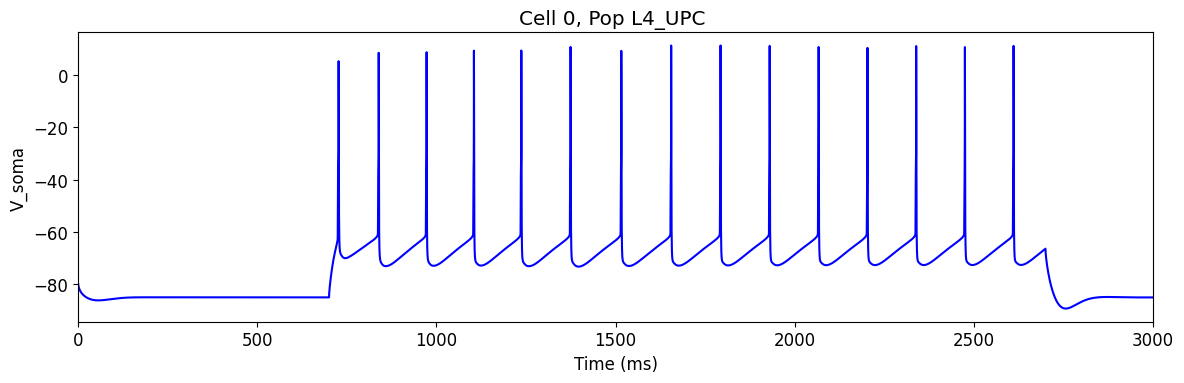

  Done; plotting time = 0.26 s

Total time = 10.60 s


In [2]:
for threshold in [150]:

    runNetPyNE(threshold)    
    
    # run(threshold)
    
    # fig, ions = plot(threshold)    
    # print("threshold =",threshold,"CAi_max",max(max(ions)))
    
    # if max(max(ions)) > 0.00009:
    #     fig.axes[-1].yaxis.set_ticks([0.000065, 0.00009, 0.00012])    
    #     fig.axes[-1].set_ylim([0.00006, max(max(ions))])
    # else:
    #     fig.axes[-1].yaxis.set_ticks([0.000065, 0.00009])    
    #     fig.axes[-1].set_ylim([0.00006, 0.0001])
        
    
    # fig.axes[-1].xgrid(True)    
    # fig.show()
    
    # fig.savefig("currents_soma_cADpyr_L4UPC_holding_threshold%d.png" % threshold, dpi = 300)

(7000.0, 8000.0)

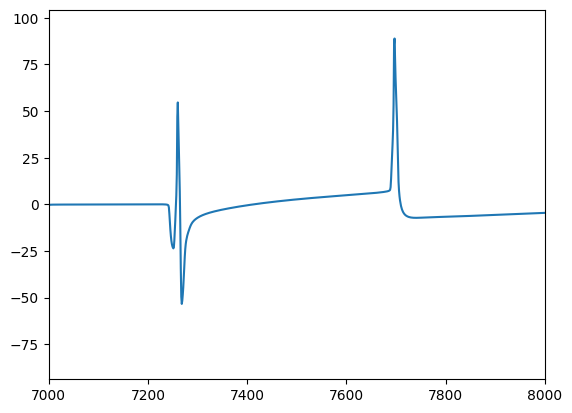

In [2]:
import numpy as np

voltage2 = np.loadtxt("python_recordings/v.dat")[:, 1] 

voltage = np.loadtxt("V_soma_cell_0.dat")[:, 1] 

from matplotlib import pyplot as plt

plt.plot(voltage2-1000*voltage[1:])
plt.xlim(7000,8000)